# Book-Crossing dataset

[Link](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) to the dataset.

The data were collected in August–September 2004 from [the Book-Crossing community](http://www.bookcrossing.com/).

This dataset consists of three tables:
*   **BX-Users**. Description of users (age, location, etc.).
*   **BX-Books**. Book descriptions. Each book has an identifier — ISBN, and also a title, year of publication, publisher, author and link to cover image on the Amazon. If a book has several authors, only the first is given in the dataset.
*   **BX-Book-Ratings**. Book ratings. Each row is a rating of a person to a book. The ratings are either explicit, expressed on a scale from 1-10, or implicit, expressed by 0.

The data are freely available for research use when acknowledged with the reference [«Improving Recommendation Lists Through Topic Diversification»](http://www2.informatik.uni-freiburg.de/~dbis/Publications/05/WWW05.html).

After downloading, the data was saved in the [data original folder](data_original).

In [1]:
import os
import sys

# Append the sys.path with the project root path
sys.path.append(os.path.dirname(os.path.abspath('')))

In [2]:
import pickle

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image
from isbnlib import is_isbn10

from locations.find_locations import find_address
from locations.parse_locations import get_countrycode, parse_address
from utils.preprocessing import convert_to_isbn13, get_weighted_rating

# To print many columns
pd.set_option('display.max_columns', 100)

# To print many rows
pd.set_option('display.max_rows', 100)

# To wrap long values
pd.set_option('display.max_colwidth', 78)

# To use seaborn style for plots
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_context('talk')
sns_palette = sns.color_palette(plt.cm.get_cmap('tab20c').colors)

## Books

### Loading

In [3]:
books_cols = ['isbn', 'book_title', 'book_author', 'year_of_publication',
              'publisher', 'img_s', 'img_m', 'img_l']
books = pd.read_csv(os.path.join('data_original', 'BX-Books.csv'),
                    sep=';', encoding='latin-1', names=books_cols,
                    low_memory=False, skiprows=1, escapechar="\\")
books.head(5)

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for ...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271379 non-null  object
 1   book_title           271379 non-null  object
 2   book_author          271378 non-null  object
 3   year_of_publication  271379 non-null  int64 
 4   publisher            271377 non-null  object
 5   img_s                271379 non-null  object
 6   img_m                271379 non-null  object
 7   img_l                271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


The dataset contains information about 271379 books. Let's take a closer look at each column.

### ISBN

In [5]:
# If all the values are unique
books['isbn'].is_unique

True

From the first rows, we can see that the majority of ISBNs are ISBN-10. Let's check if all the values are correct ISBN-10:

In [6]:
is_isbn_incorrect = ~books['isbn'].apply(is_isbn10)
print(f'Number of incorrect ISBNs: {is_isbn_incorrect.sum()}')

Number of incorrect ISBNs: 117


In [7]:
# Look at the rows with incorrect ISBN-10
books[is_isbn_incorrect].head(5)

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
6291,B00009ANY9,Cane River,Lalita Tademy,2001,Warner Books,http://images.amazon.com/images/P/B00009ANY9.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B00009ANY9.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B00009ANY9.01.LZZZZZZZ.jpg
10273,B0000A2U93,Carmilla,Joseph Sheridan Le Fanu,0,Soft Editions Ltd,http://images.amazon.com/images/P/B0000A2U93.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B0000A2U93.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B0000A2U93.01.LZZZZZZZ.jpg
11186,B0000633PU,The Story of Aladdin and the Wonderful Lamp,S. Lane Poole,0,Renaissance eBooks,http://images.amazon.com/images/P/B0000633PU.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B0000633PU.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B0000633PU.01.LZZZZZZZ.jpg
13863,B00007FYKO,Bloodcurdling Tales of Horror and the Macabre: The Best of H. P. Lovecraft,H. P. Lovecraft,0,Ballantine,http://images.amazon.com/images/P/B00007FYKO.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B00007FYKO.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B00007FYKO.01.LZZZZZZZ.jpg
13866,B00009APKU,Moby Dick,Herman Melville,0,"Outrigger Publishing, LLC",http://images.amazon.com/images/P/B00009APKU.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B00009APKU.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B00009APKU.01.LZZZZZZZ.jpg


Most of the incorrect ISBNs are ASINs — Amazon's identifiers. There are ASIN to ISBN converters, but they are not free. We can use Amazon API, also for a fee. So we have to delete rows with incorrect ISBNs because we can't fix them, and books without ISBN can not be identified.

Today, ISBN-13 is the main ISBN format. So, we will convert all ISBNs in the dataframe to ISBN-13.

In [8]:
books.loc[:, 'isbn13'] = books['isbn'].apply(convert_to_isbn13)

In [9]:
# Remove the column with ISBN-10
books.drop('isbn', axis=1, inplace=True)

# Remove rows with unknown ISBN-13
books = books.loc[~books['isbn13'].isna()]

In [10]:
# If all the values are unique
books['isbn13'].is_unique

False

In [11]:
# The duplicates appeared because of different notations of the same isbn-10
# Thus, after the conversion to ISBN-13, they became duplicates
books[books.duplicated('isbn13', keep=False)].sort_values('isbn13').head(10)

,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,isbn13
246913,One Thousand Chestnut Trees,Mira Stout,0,Harpercollins Publisher,http://images.amazon.com/images/P/000225669X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000225669X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000225669X.01.LZZZZZZZ.jpg,9780002256698
239830,One Thousand Chestnut Trees,Mira Stout,0,Harpercollins Publisher,http://images.amazon.com/images/P/000225669X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000225669X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000225669X.01.LZZZZZZZ.jpg,9780002256698
199492,Before and After,Matthew Thomas,1999,HarperCollins (UK),http://images.amazon.com/images/P/000648302X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000648302X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000648302X.01.LZZZZZZZ.jpg,9780006483021
75013,Before and After,Matthew Thomas,1999,HarperCollins (UK),http://images.amazon.com/images/P/000648302X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000648302X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000648302X.01.LZZZZZZZ.jpg,9780006483021
54573,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000649840X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000649840X.01.LZZZZZZZ.jpg,9780006498407
1261,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000649840X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000649840X.01.LZZZZZZZ.jpg,9780006498407
162670,A Small Death in Lisbon,Robert Wilson,2000,HarperCollins,http://images.amazon.com/images/P/000651202X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000651202X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000651202X.01.LZZZZZZZ.jpg,9780006512028
72820,A Small Death in Lisbon,Robert Wilson,2000,HarperCollins,http://images.amazon.com/images/P/000651202X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000651202X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000651202X.01.LZZZZZZZ.jpg,9780006512028
245667,On Death &amp; Dying,Kubler Elisabeth Ross,1970,Simon &amp; Schuster,http://images.amazon.com/images/P/002089130X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/002089130X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/002089130X.01.LZZZZZZZ.jpg,9780020891307
59437,On Death &amp; Dying,Kubler Elisabeth Ross,1970,Simon &amp; Schuster,http://images.amazon.com/images/P/002089130X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/002089130X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/002089130X.01.LZZZZZZZ.jpg,9780020891307


In [12]:
# Drop all duplicates
books.drop_duplicates(['isbn13'], inplace=True)

### Title

In [13]:
# Remove extra spaces
books['book_title'] = books['book_title'].str.strip()

# If there are empty titles
title_nans = books['book_title'].isna() | ~books['book_title'].astype(bool)
print(f'Number of empty titles: {sum(title_nans)}')

Number of empty titles: 0


In [14]:
# Check duplicate titles
non_unique_titles = books['book_title'].duplicated(keep=False)
books[non_unique_titles].sort_values('book_title').head(10)

,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,isbn13
156349,!%@ (A Nutshell handbook),Donnalyn Frey,1993,O'Reilly,http://images.amazon.com/images/P/1565920317.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1565920317.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1565920317.01.LZZZZZZZ.jpg,9781565920316
75640,!%@ (A Nutshell handbook),Donnalyn Frey,1994,O'Reilly,http://images.amazon.com/images/P/1565920465.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1565920465.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1565920465.01.LZZZZZZZ.jpg,9781565920460
267818,""" Wuthering Heights According to Spike Milligan",Spike Milligan,1995,Penguin Books Ltd,http://images.amazon.com/images/P/0140236465.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0140236465.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0140236465.01.LZZZZZZZ.jpg,9780140236460
44915,""" Wuthering Heights According to Spike Milligan",Spike Milligan,1994,Michael Joseph,http://images.amazon.com/images/P/0718137876.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0718137876.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0718137876.01.LZZZZZZZ.jpg,9780718137878
107050,"""Blackadder""",Richard Curtis,1999,Penguin Books Ltd,http://images.amazon.com/images/P/0140280359.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0140280359.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0140280359.01.LZZZZZZZ.jpg,9780140280357
98117,"""Blackadder""",Richard Curtis,1998,Michael Joseph,http://images.amazon.com/images/P/0718143728.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0718143728.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0718143728.01.LZZZZZZZ.jpg,9780718143725
66392,"""Life Was Never Meant to Be a Struggle""",Stuart Wilde,1987,White Dove International,http://images.amazon.com/images/P/0930603044.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0930603044.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0930603044.01.LZZZZZZZ.jpg,9780930603045
211120,"""Life Was Never Meant to Be a Struggle""",Stuart Wilde,1998,Hay House,http://images.amazon.com/images/P/1561705357.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1561705357.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1561705357.01.LZZZZZZZ.jpg,9781561705351
10860,"""O"" Is for Outlaw",Sue Grafton,1999,Henry Holt &amp; Company,http://images.amazon.com/images/P/0805059555.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0805059555.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0805059555.01.LZZZZZZZ.jpg,9780805059557
2529,"""O"" Is for Outlaw",SUE GRAFTON,2001,Ballantine Books,http://images.amazon.com/images/P/0449003787.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0449003787.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0449003787.01.LZZZZZZZ.jpg,9780449003787


Some books have the same titles, but different ISBNs and the year of publishing. This is because some services collect ratings for a particular ISBN (for example, [litres](https://www.litres.ru/)). The others gather books of the same content but with different formats, publishers, and year of publication in a book profile (for example, [Penguin Random House](https://www.penguinrandomhouse.com/)).

The book titles presented above contains a lot of misprints, invalid characters, etc.

In [15]:
# Unique book titles
print(f'Number of unique book titles: {len(books["book_title"].unique())}')

Number of unique book titles: 242101


### Authors

In [16]:
# Remove extra spaces
books['book_author'] = books['book_author'].str.strip()

# If there are empty authors
author_nans = books['book_author'].isna()\
    | ~books['book_author'].astype(bool)\
    | (books['book_author'] == 'Not Applicable (Na )')
books.loc[author_nans, 'book_author'] = np.nan
print(f'Number of empty authors: {sum(author_nans)}')

Number of empty authors: 287


In [17]:
# Look at the rows with empty authors
books[author_nans].head(10)

,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,isbn13
10822,"""Once More, With Feeling"" : The Script Book",NaN,2002,Simon Spotlight Entertainment,http://images.amazon.com/images/P/068985918X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/068985918X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/068985918X.01.LZZZZZZZ.jpg,9780689859182
12484,Purple Ronnie's Love Poems,NaN,2003,"Boxtree, Limited",http://images.amazon.com/images/P/0752271474.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0752271474.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0752271474.01.LZZZZZZZ.jpg,9780752271477
14046,"Campbell's Creative Cooking With Soup: Over 19,000 Delicious Mix and Match...",NaN,1990,Publications Intl,http://images.amazon.com/images/P/0881762024.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0881762024.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0881762024.01.LZZZZZZZ.jpg,9780881762020
18534,"Book of Trees (Nature, Series 536)",NaN,1986,Ladybird Books Ltd,http://images.amazon.com/images/P/0721401023.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0721401023.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0721401023.01.LZZZZZZZ.jpg,9780721401027
18615,Na Wahine: Hawaiin Proverbs &amp; Inspirational Quotes Celebrating Women i...,NaN,2003,Booklines Hawaii Ltd,http://images.amazon.com/images/P/1566475961.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1566475961.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1566475961.01.LZZZZZZZ.jpg,9781566475969
20216,365 Holiday Craft and Activities,NaN,1999,Publications Intl,http://images.amazon.com/images/P/0785335927.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0785335927.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0785335927.01.LZZZZZZZ.jpg,9780785335924
20641,God's Promises for the Graduate,NaN,1993,Thomas Nelson Inc,http://images.amazon.com/images/P/0840741391.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0840741391.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0840741391.01.LZZZZZZZ.jpg,9780840741394
24070,Book of Alternative Services of the Anglican Church of Canada,NaN,1988,Continuum Intl Pub Group,http://images.amazon.com/images/P/0919891276.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0919891276.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0919891276.01.LZZZZZZZ.jpg,9780919891272
24138,The Encyclopedia of Two-Hour Craft Projects,NaN,2001,Main Street Press,http://images.amazon.com/images/P/0806943424.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0806943424.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0806943424.01.LZZZZZZZ.jpg,9780806943428
24713,"Acog Guide to Planning for Pregnancy, Birth, and Beyond",NaN,1990,Amer College of Obstetricians &amp;,http://images.amazon.com/images/P/0915473135.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0915473135.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0915473135.01.LZZZZZZZ.jpg,9780915473137


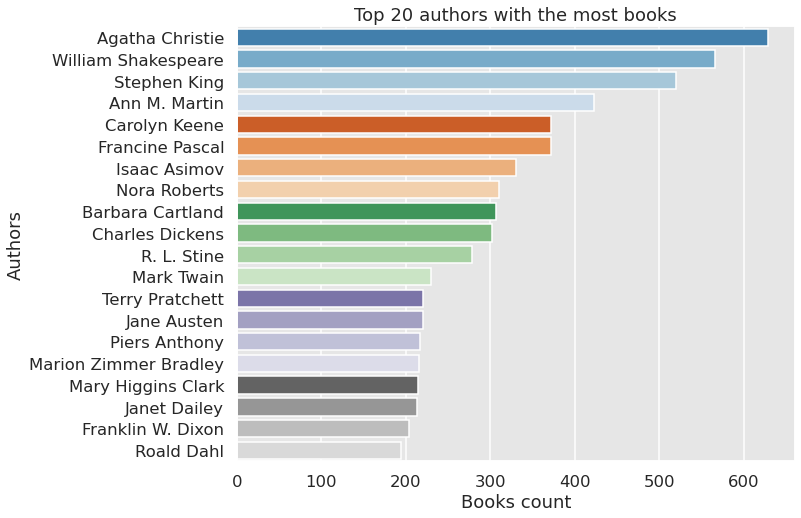

In [18]:
# Authors with the most books
authors = books['book_author'].value_counts()
top_authors = authors.head(20).reset_index()
top_authors.columns = ['authors', 'count']
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=top_authors['count'], y=top_authors['authors'],
            palette=sns_palette, ax=ax)
ax.set_ylabel('Authors')
ax.set_xlabel('Books count')
ax.set_title('Top 20 authors with the most books')
plt.show()

In [19]:
# Authors with the least books
authors.tail(10)

Lissa Hall Johnson     1
Michael Sky            1
Myers                  1
Mick Fedullo           1
J.J. Goodrich          1
Emilia Di Girolamo     1
Sourine                1
Lawhead                1
Goupil                 1
Christopher  Biffle    1
Name: book_author, dtype: int64

In [20]:
# Unique authors
print(f'Number of unique authors: {len(authors)}')

Number of unique authors: 102018


### Publisher

In [21]:
# Remove extra spaces
books['publisher'] = books['publisher'].str.strip()

# If there are empty publishers
publisher_nans = books['publisher'].isna() | ~books['publisher'].astype(bool)
print(f'Number of empty publishers: {sum(publisher_nans)}')

Number of empty publishers: 2


In [22]:
# Look at the row with empty publishers
books[publisher_nans]

,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,isbn13
128896,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/193169656X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/193169656X.01.LZZZZZZZ.jpg,9781931696562
129043,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1931696993.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1931696993.01.LZZZZZZZ.jpg,9781931696999


In [23]:
# We can fix this by googling
books.loc[books['isbn13'] == '9781931696562', 'publisher'] =\
    'NovelBooks, Inc.'
books.loc[books['isbn13'] == '9781931696999', 'publisher'] =\
    'CreateSpace Independent Publishing Platform'

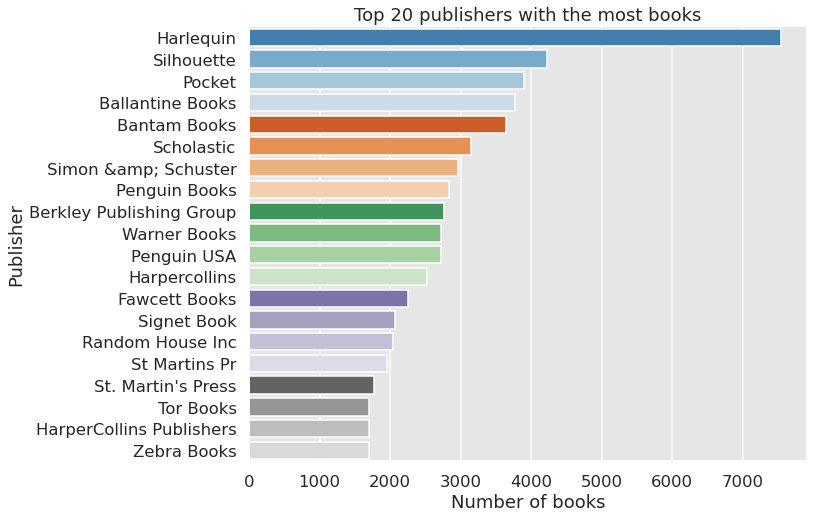

In [24]:
# Publishers with the most books
publishers = books['publisher'].value_counts()
top_publishers = publishers.head(20).reset_index()
top_publishers.columns = ['publisher', 'count']
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=top_publishers['count'],
            y=top_publishers['publisher'],
            palette=sns_palette, ax=ax)
ax.set_ylabel('Publisher')
ax.set_xlabel('Number of books')
ax.set_title('Top 20 publishers with the most books')
plt.show()

In [25]:
# Publishers with the least books
publishers.tail(10)

Gansevoort Pr                    1
Snosrap Publishing               1
Sands Pub Llc                    1
Shadow Line Press                1
ImaJinn Books                    1
Windstream Publishing Company    1
Polaris Books                    1
Hannover House                   1
Amber Quill Press, LLC.          1
Connaught                        1
Name: publisher, dtype: int64

In [26]:
# Unique publishers
print(f'Number of unique publishers: {len(publishers)}')

Number of unique publishers: 16786


### Year of publication

In [27]:
books['year_of_publication'].describe()

count    270947.000000
mean       1960.156222
std         256.505655
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: year_of_publication, dtype: float64

There are zeros and values greater than the data collection date — 2004.

In [28]:
# Convert zeros to None
books.loc[books['year_of_publication'] == 0, 'year_of_publication'] = np.nan

In [29]:
# Look at rows where year of publication is greater than 2004
mask = books['year_of_publication'] > 2004
print(f'Number of dates more than 2004: {mask.sum()}')
books.loc[mask].head(10)

Number of dates more than 2004: 72


,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,isbn13
3541,Red Dwarf,Grant Naylor,2005.0,Penguin Books Ltd,http://images.amazon.com/images/P/0140124373.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0140124373.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0140124373.01.LZZZZZZZ.jpg,9780140124378
12783,A Rose in Winter,Kathleen E. Woodiwiss,2011.0,Harper Mass Market Paperbacks,http://images.amazon.com/images/P/0380816792.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0380816792.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0380816792.01.LZZZZZZZ.jpg,9780380816798
26167,The Astrologer's Handbook,Frances Sakoian,2005.0,HarperResource,http://images.amazon.com/images/P/006272004X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/006272004X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/006272004X.01.LZZZZZZZ.jpg,9780062720047
30011,The Royals,Kitty Kelley,2020.0,Bausch &amp; Lombard,http://images.amazon.com/images/P/068160204X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/068160204X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/068160204X.01.LZZZZZZZ.jpg,9780681602045
37488,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEACHER BOOKS),Coville,2030.0,Aladdin,http://images.amazon.com/images/P/0671746103.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671746103.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671746103.01.LZZZZZZZ.jpg,9780671746100
38523,The Five Love Languages: Five Love Languages,Gary Chapman,2005.0,Moody Publishers,http://images.amazon.com/images/P/1881273156.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1881273156.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1881273156.01.LZZZZZZZ.jpg,9781881273158
42562,Thunderball (James Bond 007),Ian Fleming,2005.0,Penguin Books Ltd,http://images.amazon.com/images/P/0141002999.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0141002999.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0141002999.01.LZZZZZZZ.jpg,9780141002996
55387,A Woman of No Importance (Penguin Popular Classics),Oscar Wilde,2005.0,Penguin Books Ltd,http://images.amazon.com/images/P/0140622454.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0140622454.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0140622454.01.LZZZZZZZ.jpg,9780140622454
55679,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY TEACHER BOOKS),Bruce Coville,2030.0,Aladdin,http://images.amazon.com/images/P/0671791990.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671791990.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671791990.01.LZZZZZZZ.jpg,9780671791995
58333,"PS, I Love You",Cecelia Ahern,2005.0,Hyperion,http://images.amazon.com/images/P/0786890754.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0786890754.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0786890754.01.LZZZZZZZ.jpg,9780786890750


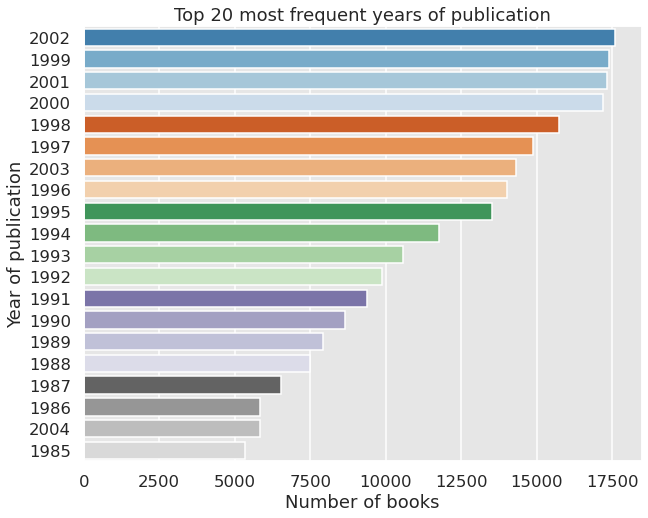

In [30]:
# Show most frequent years of publication
years = books['year_of_publication'].value_counts().head(20).reset_index()
years.columns = ['year', 'count']
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=years['count'], y=years['year'].astype(int).astype(str),
            palette=sns_palette, ax=ax)
ax.set_ylabel('Year of publication')
ax.set_xlabel('Number of books')
ax.set_title('Top 20 most frequent years of publication')
plt.show()

### Cover

In [31]:
# If there are missing values
for col in ['img_s', 'img_m', 'img_l']:
    books[col] = books[col].str.strip()
    nans = books[col].isna() | ~books[col].astype(bool)
    print(f'Number of missing values in column "{col}": {nans.sum()}')

Number of missing values in column "img_s": 0
Number of missing values in column "img_m": 0
Number of missing values in column "img_l": 0


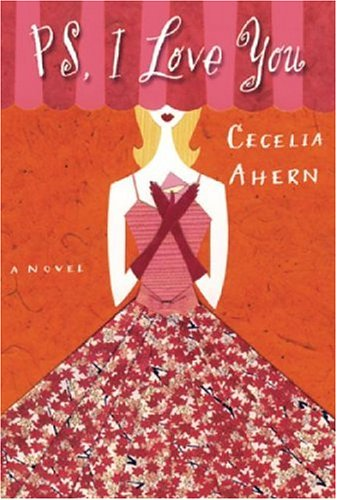

In [32]:
# Look at a cover
Image(books.loc[58333, 'img_l'])

In [33]:
# However, some images do not exist
Image(books.loc[42562, 'img_l'])

### Conclusions

The book data are so poor. There are no content descriptions, genres, and formats of the book. Only one author is listed, even if more than one author wrote the book. The column with the year of publication contains errors. The cover images are of poor quality or missing.

In [34]:
print(f'Number of books after cleaning: {len(books)}')

Number of books after cleaning: 270947


## Users

### Loading

In [35]:
users_cols = ['user_id', 'location', 'age']
users = pd.read_csv(os.path.join('data_original', 'BX-Users.csv'),
                    sep=";", encoding='latin-1', names=users_cols,
                    low_memory=False, skiprows=1)

In [36]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


There are 278858 unique users.

In [37]:
users.head(5)

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [38]:
# If there are duplicates
users.duplicated(['user_id']).any()

False

### Age

In [39]:
# Missing values
print(f'Number of missing values in the age column: '
      f'{users["age"].isna().sum()}')

Number of missing values in the age column: 110762


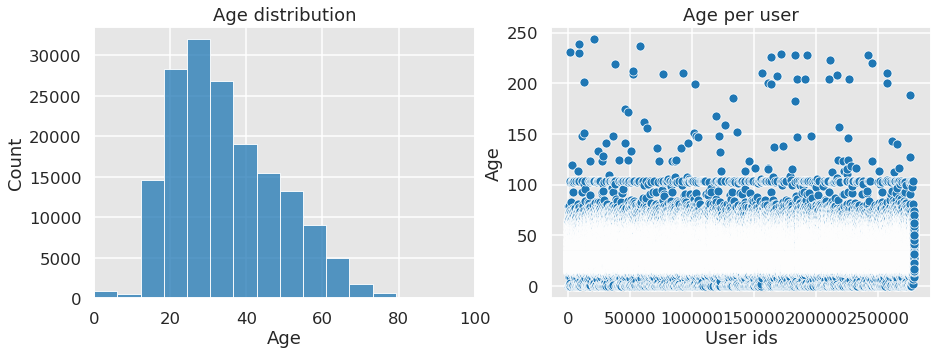

In [40]:
# Age plots
_, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(users['age'], bins=40, ax=axs[0])
sns.scatterplot(data=users, x='user_id', y='age', ax=axs[1])
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Count')
axs[0].set_title('Age distribution')
axs[0].set_xlim(0, 100)
axs[1].set_xlabel('User ids')
axs[1].set_ylabel('Age')
axs[1].set_title('Age per user')
plt.show()

In [41]:
# Description
users['age'].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: age, dtype: float64

Almost half of the users have no age. At the same time, some people's age is zero or exceeds the permissible limits.

### Location

The location column contains information about the user's country and city. But often the information is in an incorrect form.

In [42]:
users['location'].head(10)

0                    nyc, new york, usa
1             stockton, california, usa
2       moscow, yukon territory, russia
3             porto, v.n.gaia, portugal
4    farnborough, hants, united kingdom
5         santa monica, california, usa
6                   washington, dc, usa
7              timmins, ontario, canada
8            germantown, tennessee, usa
9            albacete, wisconsin, spain
Name: location, dtype: object

Let us try to find the locations with free geocoding services. We will search for locations and extract coordinates and country from the response. This can be useful for recommendations based on user location.

In [43]:
# For example
find_address('nyc, new york, usa')

{'engine': 'photon',
 'data': {'geometry': {'coordinates': [-73.97533355992071, 40.73926685],
   'type': 'Point'},
  'type': 'Feature',
  'properties': {'osm_id': 150365209,
   'extent': [-73.9767978, 40.7401153, -73.9735603, 40.738185],
   'country': 'United States',
   'city': 'New York',
   'countrycode': 'US',
   'postcode': '10010',
   'locality': 'Kips Bay',
   'type': 'house',
   'osm_type': 'W',
   'osm_key': 'amenity',
   'housenumber': '462',
   'street': '1st Avenue',
   'district': 'Manhattan',
   'osm_value': 'hospital',
   'name': 'NYC Health + Hospitals/Bellevue',
   'state': 'New York'}}}

In [44]:
# Get unique locations
unique_locations = pd.Series(users['location'].unique())
print(f'Number of unique places: {len(unique_locations)}')

# Save unique locations for geocoding
path_unique = os.path.join('data_interm', 'unique_locations.pkl')
if not os.path.exists(path_unique):
    unique_locations.to_pickle(path_unique)

Number of unique places: 57339


The geocoding process with [find_locations.py](locations/find_locations.py) script takes about five hours. Thus, the results were saved to the hard disk and loaded further:

In [45]:
# Load geocoded info
path_geocoded = os.path.join('data_interm', 'geocoded_locations.pkl')
with open(path_geocoded, 'rb') as file:
    geocoded_locations = pickle.load(file)

In [46]:
# Parse geocoding info
parsed_locations = {}
for location, info in geocoded_locations.items():
    parsed_locations[location] = parse_address(info)

# Convert to dataframe
parsed_locations_pd = pd.DataFrame(
    parsed_locations, index=['country', 'lat', 'lon']).T
parsed_locations_pd.head(10)

,country,lat,lon
"nyc, new york, usa",United States,40.739267,-73.975334
"stockton, california, usa",United States,37.989284,-121.322376
"moscow, yukon territory, russia",Russia,55.484151,37.303741
"porto, v.n.gaia, portugal",Portugal,41.13001,-8.605842
"farnborough, hants, united kingdom",United Kingdom,51.291869,-0.753984
"santa monica, california, usa",United States,34.020457,-118.495677
"washington, dc, usa",United States,38.929858,-77.033324
"timmins, ontario, canada",Canada,48.477473,-81.330414
"germantown, tennessee, usa",United States,35.086758,-89.810086
"albacete, wisconsin, spain",Spain,38.947305,-1.864374


In [47]:
mask = parsed_locations_pd['country'].isna()
print(f'Number of missing locations: {sum(mask)}')
parsed_locations_pd[mask].head(10)

Number of missing locations: 34


,country,lat,lon
"westvancouver, ,",NaN,NaN,NaN
", ,",NaN,NaN,NaN
"taiblan, alabama, afganstand holla !!",NaN,NaN,NaN
"------, -------, -------",NaN,NaN,NaN
"zoolooriver, ,",NaN,NaN,NaN
"mã?â©rida, yucatã?â¡n, mã?â©xico",NaN,NaN,NaN
"coral bay, st john, us virgin islands, caribbean sea",NaN,17.73951,-64.783592
"znuizinbt, fzmnuoi, tdzimi",NaN,NaN,NaN
"een klein dorpje in de buurt van goes, n/a, netherlands",NaN,12.194274,-68.249092
"saipan, northern marianas provinces, usa",NaN,15.1355,145.7015


In [48]:
# Correct some values manually with Google Maps:
parsed_locations_pd.loc['westvancouver, ,'] =\
    ('Canada', 49.32840991767837, -123.15926137833281)
parsed_locations_pd.loc['coral bay, st john, us virgin islands, caribbean sea'] =\
    ('United States', 18.34882362061232, -64.71319203340178)
parsed_locations_pd.loc['saipan, northern marianas provinces, usa'] =\
    ('United States', 15.189869606062938, 145.7483797156802)
parsed_locations_pd.loc['nicosia, island in the mediterranean, cyprus'] =\
    ('Cyprus', 35.18607470944445, 33.385900415581354)
parsed_locations_pd.loc['castries, caribbean, caribbean sea'] =\
    ('Saint Lucia', 14.011170945260448, -60.992211337784845)
parsed_locations_pd.loc['s, s, china'] =\
    ('China', 33.76472200405407, 103.92501603483987)
parsed_locations_pd.loc['mcmurdo station, antarctica, antarctica'] =\
    ('Antarctica', -77.81526105657824, 166.6635934565992)
parsed_locations_pd.loc['ladyfane, pei, canada'] =\
    ('Canada', 46.28099646038078, -63.52168127292505)
parsed_locations_pd.loc['een klein dorpje in de buurt van goes, n/a, netherlands'] =\
    ('Netherlands', 51.56572335286174, 3.9104089952127663)
parsed_locations_pd.loc['ladyfane, pei, canada'] =\
    ('United States', -14.183373550987193, -170.73119286079935)
parsed_locations_pd.loc['bismarck, ,'] = (np.nan, np.nan, np.nan)
parsed_locations_pd.loc['depends, europe, europe : uk, france, switzerland'] =\
    (np.nan, np.nan, np.nan)
parsed_locations_pd.loc['rasdal, rogabos, cayman islands'] =\
    ('Cayman Islands', 19.56991374313513, -81.21649205542728)

In [49]:
# Convert country names to alpha-2 code:
country_codes = {}
for country in parsed_locations_pd['country'].dropna().unique():
    code = get_countrycode(country)
    if code:
        country_codes[country] = code

In [50]:
# Which countries were not converted to alpha-2 code
all_countries = set(parsed_locations_pd['country'].unique())
parsed_codes = set(country_codes.keys())
all_countries.difference(parsed_codes)

{'Hong Kong S.A.R.',
 'Kosovo',
 'Macedonia',
 'Palestine',
 'Palestinian Territory',
 'Somaliland',
 'St. Lucia',
 'Vatican City',
 nan}

In [51]:
# Correct manually
country_codes['Hong Kong S.A.R.'] = 'HK'
country_codes['Kosovo'] = 'XK'
country_codes['Macedonia'] = 'MK'
country_codes['Palestine'] = 'PS'
country_codes['Palestinian Territory'] = 'PS'
country_codes['Somaliland'] = 'SO'
country_codes['St. Lucia'] = 'LC'
country_codes['Vatican City'] = 'VA'

In [52]:
# Add information about countries to the dataframe
parsed_locations_pd['country'].replace(country_codes, inplace=True)
parsed_locations_pd = parsed_locations_pd.reset_index()\
    .rename(columns={'index': 'location'})

# Add the information about locations to the dataframe `users`
users = users.merge(parsed_locations_pd, on='location')
users.head(10)

,user_id,location,age,country,lat,lon
0,1,"nyc, new york, usa",NaN,US,40.739267,-73.975334
1,1217,"nyc, new york, usa",NaN,US,40.739267,-73.975334
2,5569,"nyc, new york, usa",NaN,US,40.739267,-73.975334
3,5806,"nyc, new york, usa",NaN,US,40.739267,-73.975334
4,8863,"nyc, new york, usa",16.0,US,40.739267,-73.975334
5,19145,"nyc, new york, usa",NaN,US,40.739267,-73.975334
6,20574,"nyc, new york, usa",45.0,US,40.739267,-73.975334
7,30454,"nyc, new york, usa",17.0,US,40.739267,-73.975334
8,30767,"nyc, new york, usa",NaN,US,40.739267,-73.975334
9,33364,"nyc, new york, usa",44.0,US,40.739267,-73.975334


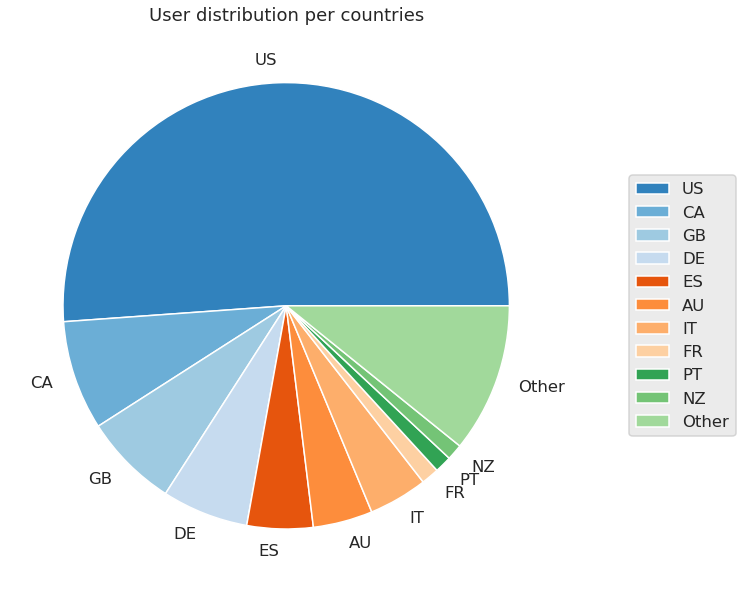

In [53]:
# Top most frequent countries
stat = users['country'].value_counts()
top_10 = stat[:10]
top_10['Other'] = stat[10:].sum()
top_10.plot(kind='pie', subplots=True, figsize=(10, 20), x='countries',
            colors=sns_palette)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.title('User distribution per countries')
plt.ylabel('')
plt.show()

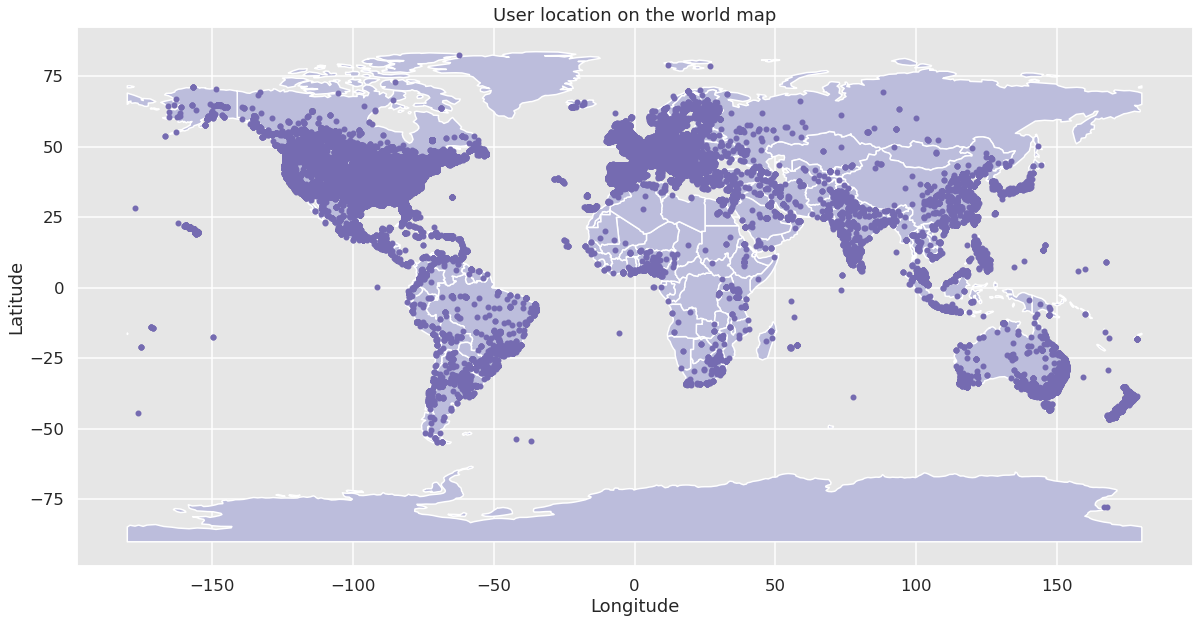

In [54]:
# Plot user location on the world map
_, ax = plt.subplots(figsize=(20, 15))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='#BCBDDC', ax=ax)
users.plot(x='lon', y='lat', kind='scatter', ax=ax, color='#756BB1')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('User location on the world map')
plt.show()

### Conclusions

We have processed user information as best we can, but the information is still not reliable. The locations may be inaccurate, but they are better than they were.

## Ratings

### Loading

In [55]:
rating_cols = ['user_id', 'isbn', 'book_rating']
ratings = pd.read_csv(os.path.join('data_original', 'BX-Book-Ratings.csv'),
                      sep=';', encoding='latin-1', names=rating_cols,
                      low_memory=False, skiprows=1)
ratings.rename(columns={'book_rating': 'rating'}, inplace=True)
ratings.head(5)

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### ISBNs and users

In [56]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1149780 non-null  int64 
 1   isbn     1149780 non-null  object
 2   rating   1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [57]:
# If there are duplicates
ratings.duplicated(['user_id', 'isbn']).any()

False

In [58]:
# If all the users, who left ratings, are in the `users` dataset
ratings['user_id'].isin(users['user_id']).all()

True

In [59]:
# Convert ISBN-10 into ISBN-13
ratings.loc[:, 'isbn13'] = ratings['isbn'].apply(convert_to_isbn13)

# Drop columns with ISBN-10
ratings.drop('isbn', axis=1, inplace=True)

# Drop book ratings which are not in the `books` dataset
mask = ratings['isbn13'].isin(books['isbn13'])
ratings = ratings.loc[mask]

In [60]:
# The previous transformations lead to duplicated ratings
# Let's drop them
ratings.drop_duplicates(['user_id', 'isbn13'],
                        keep='first', inplace=True)

### Rating values

In [61]:
ratings['rating'].describe()

count    1.031621e+06
mean     2.839841e+00
std      3.854408e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [62]:
# Check for missing values
ratings['rating'].isna().any()

False

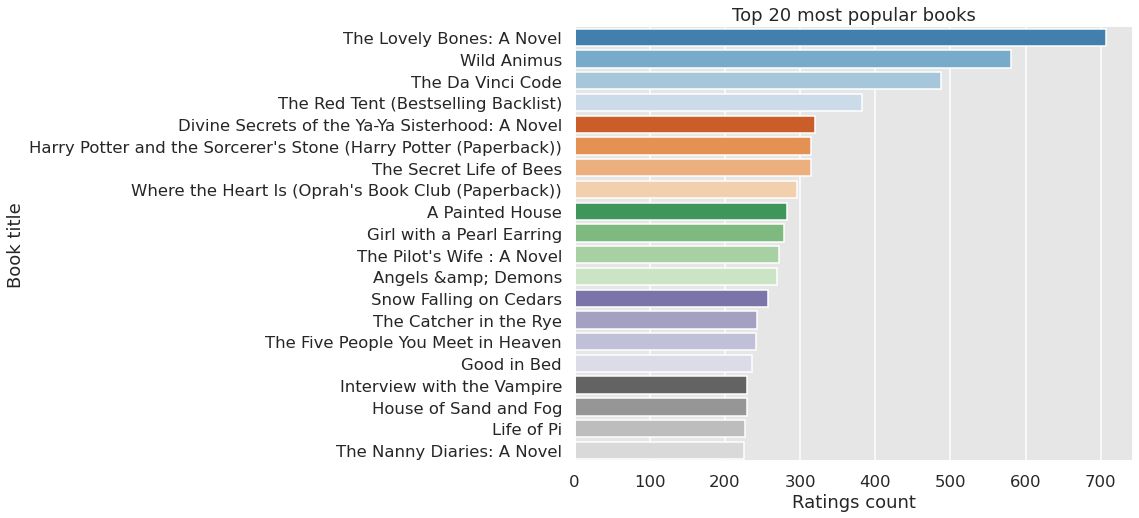

In [63]:
# Select only explicit ratings
explicit_ratings = ratings[ratings['rating'] != 0]

# The most popular books
ratings_per_book = explicit_ratings.groupby('isbn13')
popular_books = ratings_per_book[['rating']].count()\
    .rename(columns={'rating': 'rating_count'})\
    .sort_values(by='rating_count', ascending=False)
popular_books_top = popular_books.head(20)
popular_books_top = pd.merge(popular_books_top,
                             books[['isbn13', 'book_title']],
                             right_on='isbn13',
                             left_index=True)

# Show
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=popular_books_top['rating_count'],
            y=popular_books_top['book_title'],
            palette=sns_palette, ax=ax)
ax.set_ylabel('Book title')
ax.set_xlabel('Ratings count')
ax.set_title('Top 20 most popular books')
plt.show()

Let's calculate weighted ratings of books. To use usual rating is not the best idea, because a book with a rating of 9 from 10 voters will be considered 'better' than a book with a rating of 8.9 from 10,000 voters. Thus, it is better to use 'weighted rating'. See more details [in the Datacamp article](https://www.datacamp.com/community/tutorials/recommender-systems-python).

In [64]:
min_book_rate_count = popular_books['rating_count'].quantile(0.90)
mean_book_rate = explicit_ratings['rating'].mean()
high_rated_books = ratings_per_book\
    .apply(get_weighted_rating, mean_rate=mean_book_rate,
           min_rate_count=min_book_rate_count)\
    .to_frame(name='weighted_rating')

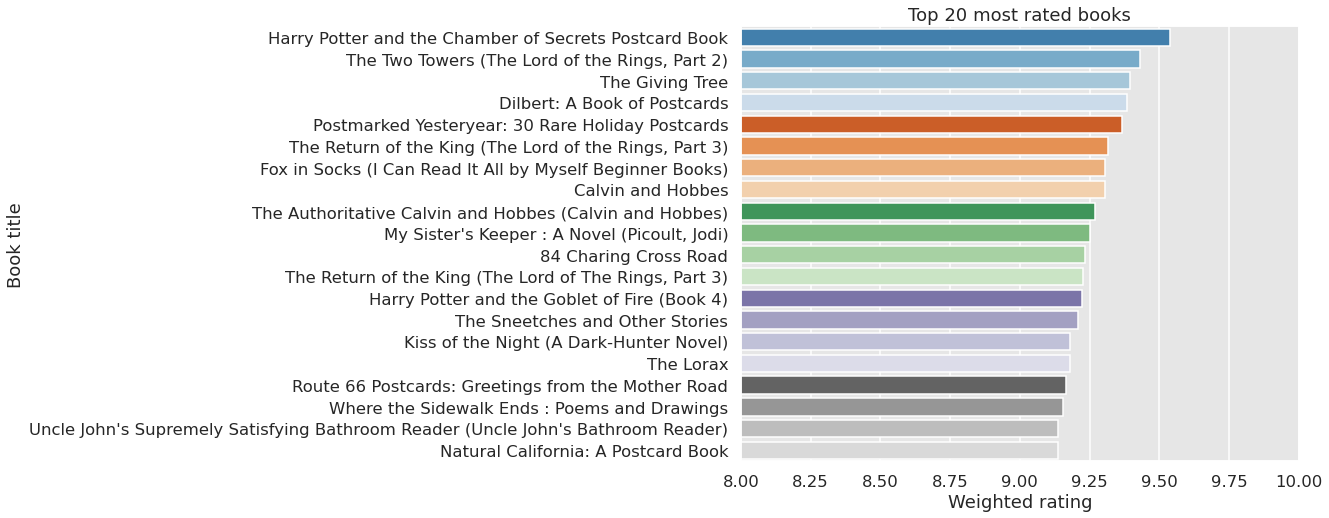

In [65]:
high_rated_books_top = high_rated_books\
    .sort_values(by='weighted_rating', ascending=False).head(20)
high_rated_books_top = pd.merge(high_rated_books_top,
                                books[['isbn13', 'book_title']],
                                right_on='isbn13',
                                left_index=True)

# Show
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=high_rated_books_top['weighted_rating'],
            y=high_rated_books_top['book_title'],
            palette=sns_palette, ax=ax, ci=None)
ax.set_ylabel('Book title')
ax.set_xlim(8, 10)
ax.set_xlabel('Weighted rating')
ax.set_title('Top 20 most rated books')
plt.show()

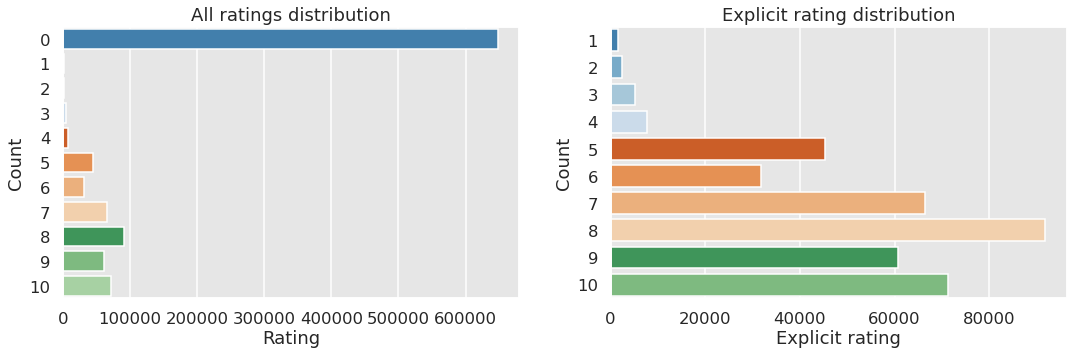

In [66]:
_, axs = plt.subplots(ncols=2, figsize=(18, 5))

# All ratings
sns.countplot(data=ratings, y='rating',
              ax=axs[0], palette=sns_palette)
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Count')
axs[0].set_title('All ratings distribution')

# Only explicit
sns.countplot(data=explicit_ratings, y='rating',
              ax=axs[1], palette=sns_palette)
axs[1].set_xlabel('Explicit rating')
axs[1].set_ylabel('Count')
axs[1].set_title('Explicit rating distribution')
plt.show()

### Conclusions

In [67]:
print(f'Number of ratings: {len(ratings)}')

Number of ratings: 1031621


In [68]:
ratings_gp = ratings.groupby('isbn13')['rating'].count()
print(f'Number of books: {len(books)}')
print(f'Number of books that have at least one rating: {len(ratings_gp)}')
print(f'Number of books that have at least five ratings: '
      f'{len(ratings_gp[ratings_gp >= 5])}')

Number of books: 270947
Number of books that have at least one rating: 269747
Number of books that have at least five ratings: 40954


In [69]:
ratings_us = ratings.groupby('user_id')['rating'].count()
print(f'Number of users: {len(users)}')
print(f'Number of users who left at least one rating: {len(ratings_us)}')
print(f'Number of users who left at least five ratings: '
      f'{len(ratings_us[ratings_us >= 5])}')

Number of users: 278858
Number of users who left at least one rating: 92244
Number of users who left at least five ratings: 20433


## Save

In [70]:
books.to_csv(os.path.join('data_prep', 'books.csv'), index=False)
users.to_csv(os.path.join('data_prep', 'users.csv'), index=False)
ratings.to_csv(os.path.join('data_prep', 'ratings.csv'), index=False)